In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [145]:
df = pd.read_csv('df.csv')
print(df.shape)
df.head()

(13246, 6)


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


##### We know the price of house and the size of house. Let's calculate the <em>Price per sqft</em> and save it in new column.

In [146]:
df['price_per_sqft'] = df['price'] * 100000/ df['total_sqft']  # multiplying by 100000(1 lakh) because price is in lakhs
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [147]:
print(len(df.location.unique()))
df.location.unique()

1304


array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [148]:
def change(x):
    return x.strip()

In [149]:
df.location = df.location.apply(change)
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head(10)

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
Yelahanka                210
Uttarahalli              186
Hebbal                   176
Marathahalli             175
Raja Rajeshwari Nagar    171
Name: location, dtype: int64

##### Let's find out how many location has less than or equal to 10 houses

In [150]:
len(location_stats[location_stats<=10])

1052

##### There are 1052 location which have less than or equal to 10 houses.

In [151]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [152]:
df.location = df.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df.location.unique())

242

In [153]:
df.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


##### Before applying the function the count of location.unique was <strong>1293</strong>.
##### After applying the function, the count of location.unique is <strong>242</strong>.

##### So, we successfully separated the values in location feature.

#### As we can observe here: 
    1. The size of 1 bedroom is around 500sqft ( total_sqft_avg / bhk ~ 500sqft).
    2. Now we will set some threshold size of 1 bedroom ( say 300 sqft ) and remove those error values( where size < 300)

##### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely    

In [154]:
len(df[df.total_sqft / df.bhk < 300])  # length of rows with error values

744

In [155]:
df.shape

(13246, 7)

##### As we can see there are 744 rows out of total (13246) rows of size below the threshold size (size< 300sqft)

##### Now we will make a new dataset excluding these(744) error values

In [156]:
df1 = df[~(df.total_sqft/ df.bhk < 300)]
df1.shape

(12502, 7)

##### Now, the number of rows is = 12502

## Outlier Removal Using Standard Deviation and Mean

In [157]:
df1.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

##### Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. 
##### We should remove outliers per location using mean and one standard deviation

In [158]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df2 = remove_pps_outliers(df1)
df2.shape

(10241, 7)

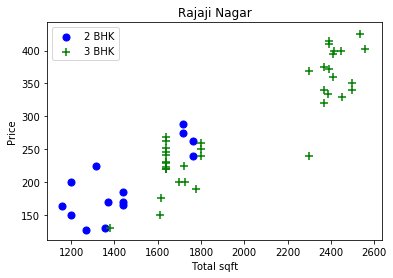

In [159]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk==2)]
    bhk3 = df[(df.location == location) & (df.bhk==3)]

    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel('Total sqft')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

plot_scatter_chart(df2,"Rajaji Nagar")    

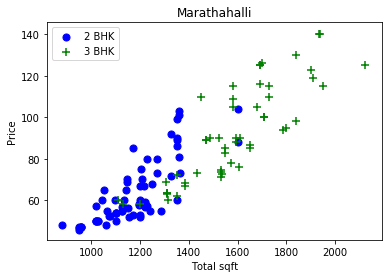

In [160]:
plot_scatter_chart(df2,"Marathahalli")    

##### As blue dot --> 2 bhk
##### and green cross --> 3 bhk
##### We can observe in 1st diagram that at around 1700 total sqft, Price of 2bhk is higher than 3bhk at same total sqft.
##### Which is unlikely possible. This occurs in various other locations. 
##### We will fix these types of outliers( errors)


### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

##### {
#####  '1' : {
#####       'mean' : 4000,
#####        'std' : 2000,
#####        'count' : 34
#####      },
#####      '2' : {
#####        'mean' : 4300,
#####        'std' : 2300,
#####        'count' : 22
#####      },  
##### }

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [161]:
# function to remove outliers

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df3 = remove_bhk_outliers(df2)
# df8 = df7.copy()
df3.shape


(7329, 7)

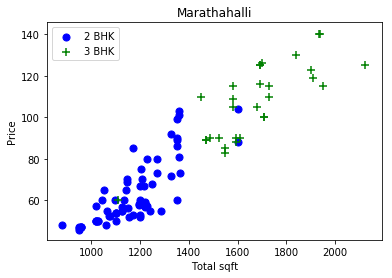

In [162]:
plot_scatter_chart(df3,"Marathahalli")    

### Now, i will plot Before V/s After diagrams, so it will be clearly understandable

Text(0.5, 1.0, 'Rajaji Nagar | After')

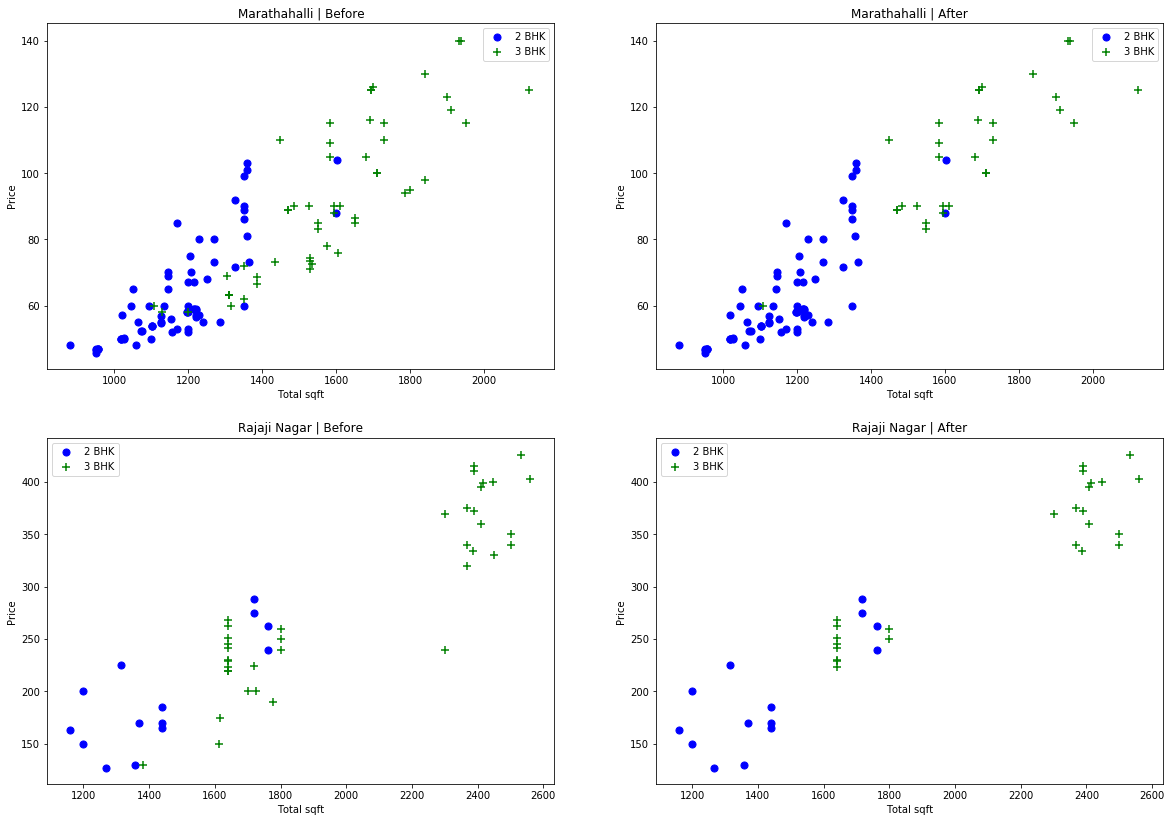

In [163]:
plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
plot_scatter_chart(df2,"Marathahalli")  
plt.title('Marathahalli | Before')


plt.subplot(2,2,2)
plot_scatter_chart(df3, "Marathahalli")
plt.title("Marathahalli | After")

plt.subplot(2,2,3)
plot_scatter_chart(df2,"Rajaji Nagar")
plt.title('Rajaji Nagar | Before')


plt.subplot(2,2,4)
plot_scatter_chart(df3,"Rajaji Nagar")
plt.title("Rajaji Nagar | After")

Text(0, 0.5, 'Count')

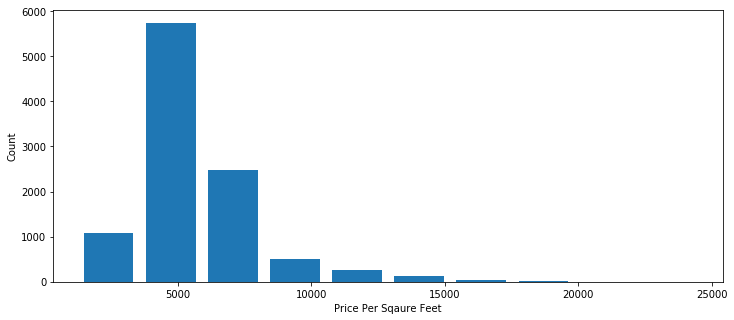

In [164]:
plt.figure(figsize=(12,5))
plt.hist(df2.price_per_sqft, rwidth= 0.8)
plt.xlabel('Price Per Sqaure Feet')
plt.ylabel('Count')

## Let's explore the bathroom column

In [165]:
df2.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

#### We see that there are even 10+ bathrooms in 1 house, that is not likely possible.

In [166]:
df2[df2.bath > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

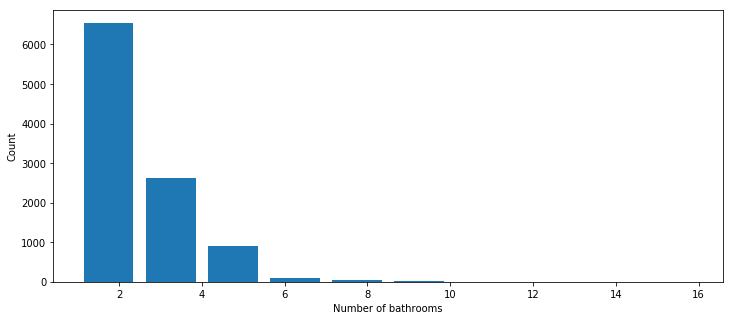

In [167]:
plt.figure(figsize=(12,5))
plt.hist(df2.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [168]:
# Finding the outliers
print(df2.shape, '\n')

df2[df2.bath>df2.bhk+2]

# if you have 2 bhk, you should have bathroom = bhk+2 (threshold)

(10241, 7) 



,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8411,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


##### We will remove these outliers by making a new dataframe excluding these outliers

In [169]:
df3 = df2[df2.bath < df2.bhk+2]
df3.shape

(10147, 7)

##### Shape of df3 is different from shape of df2, because Outliers have been removed

##### Now, I will create a new dataframe and drop some un-wanted columns like size and price_per_sqft

In [170]:
df4 = df3.drop(['size', 'price_per_sqft'], 1)
df4.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


## And will export this dataframe for further use

In [171]:
df4.to_csv('df5.csv', index=False)